#https://discuss.dgl.ai/t/how-to-plot-the-attention-weights/206
#https://discuss.dgl.ai/t/blog-understand-graph-attention-network/118
#https://github.com/dmlc/dgl/issues/608

In [2]:
from dgl.nn.pytorch import GATConv
import torch
import torch.nn as nn
import torch.nn.functional as F

Using backend: pytorch


In [3]:
class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        # equation (4)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h': h}

    def forward(self, h):
        # equation (1)
        z = self.fc(h)
        self.g.ndata['z'] = z
        # equation (2)
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

In [4]:
class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge

    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average
            return torch.mean(torch.stack(head_outs))

In [5]:
class GAT(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        return h

In [6]:
from dgl import DGLGraph
from dgl.data import citation_graph as citegrh
import networkx as nx

def load_cora_data():
    data = citegrh.load_cora()
    features = torch.FloatTensor(data.features)
    labels = torch.LongTensor(data.labels)
    mask = torch.BoolTensor(data.train_mask)
    g = DGLGraph(data.graph)
    return g, features, labels, mask

In [7]:
import time
import numpy as np

g, features, labels, mask = load_cora_data()

# create the model, 2 heads, each head has hidden size 8
net = GAT(g,
          in_dim=features.size()[1],
          hidden_dim=8,
          out_dim=7,
          num_heads=2)

# create optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

Loading from cache failed, re-processing.
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


C:\Users\ME\Anaconda3\envs\tf-gpu5\lib\site-packages\dgl\data\utils.py:285: UserWarning: Property dataset.feat will be deprecated, please use g.ndata['feat'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
C:\Users\ME\Anaconda3\envs\tf-gpu5\lib\site-packages\dgl\data\utils.py:285: UserWarning: Property dataset.label will be deprecated, please use g.ndata['label'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
C:\Users\ME\Anaconda3\envs\tf-gpu5\lib\site-packages\dgl\data\utils.py:285: UserWarning: Property dataset.train_mask will be deprecated, please use g.ndata['train_mask'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
C:\Users\ME\Anaconda3\envs\tf-gpu5\lib\site-packages\dgl\data\utils.py:285: UserWarning: Property dataset.graph will be deprecated, please use dataset.g instead.
  warnings.warn('Property {} will be deprecated, p

In [8]:
g.edata['e']

KeyError: 'e'

In [9]:
features.shape

torch.Size([2708, 1433])

In [10]:
labels.shape

torch.Size([2708])

In [11]:
g.number_of_nodes

<bound method DGLHeteroGraph.number_of_nodes of Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={}
      edata_schemes={})>

In [12]:
# main loop
dur = []
for epoch in range(30):
    if epoch >= 3:
        t0 = time.time()

    logits = net(features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[mask], labels[mask])
    
    pred = logits.argmax(1)
    train_acc = (pred[mask] == labels[mask]).float().mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 3:
        dur.append(time.time() - t0)

    print("Epoch {:05d} | Loss {:.4f} | Acc {:.4f} | Time(s) {:.4f}".format(
        epoch, loss.item(), train_acc.item(), np.mean(dur)))

C:\Users\ME\Anaconda3\envs\tf-gpu5\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\ME\Anaconda3\envs\tf-gpu5\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Loss 1.9485 | Acc 0.1643 | Time(s) nan
Epoch 00001 | Loss 1.9466 | Acc 0.1786 | Time(s) nan
Epoch 00002 | Loss 1.9448 | Acc 0.2214 | Time(s) nan
Epoch 00003 | Loss 1.9429 | Acc 0.2786 | Time(s) 0.2803
Epoch 00004 | Loss 1.9410 | Acc 0.3357 | Time(s) 0.3562
Epoch 00005 | Loss 1.9391 | Acc 0.3929 | Time(s) 0.3452
Epoch 00006 | Loss 1.9372 | Acc 0.4214 | Time(s) 0.3763
Epoch 00007 | Loss 1.9354 | Acc 0.4643 | Time(s) 0.3655
Epoch 00008 | Loss 1.9335 | Acc 0.5000 | Time(s) 0.3554
Epoch 00009 | Loss 1.9316 | Acc 0.5500 | Time(s) 0.3404
Epoch 00010 | Loss 1.9297 | Acc 0.5786 | Time(s) 0.3432
Epoch 00011 | Loss 1.9278 | Acc 0.6071 | Time(s) 0.3503
Epoch 00012 | Loss 1.9259 | Acc 0.6500 | Time(s) 0.3424
Epoch 00013 | Loss 1.9240 | Acc 0.6714 | Time(s) 0.3498
Epoch 00014 | Loss 1.9221 | Acc 0.7071 | Time(s) 0.3560
Epoch 00015 | Loss 1.9202 | Acc 0.7429 | Time(s) 0.3494
Epoch 00016 | Loss 1.9183 | Acc 0.7786 | Time(s) 0.3409
Epoch 00017 | Loss 1.9163 | Acc 0.8000 | Time(s) 0.3351
E

In [38]:
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import torch
from dgl import DGLGraph

In [39]:
def plot(g, attention, ax, nodes_to_plot=None, nodes_labels=None,
         edges_to_plot=None, nodes_pos=None, nodes_colors=None,
         edge_colormap=plt.cm.Reds):
   
    if nodes_to_plot is None:
        nodes_to_plot = sorted(g.nodes())
    if edges_to_plot is None:
        assert isinstance(g, nx.DiGraph), 'Expected g to be an networkx.DiGraph' \
                                          'object, got {}.'.format(type(g))
        edges_to_plot = sorted(g.edges())
    nx.draw_networkx_edges(g, nodes_pos, edgelist=edges_to_plot,
                           edge_color=attention, edge_cmap=edge_colormap,
                           width=1, alpha=0.5, ax=ax, edge_vmin=0,
                           edge_vmax=1)

    if nodes_colors is None:
        nodes_colors = sns.color_palette("deep", max(nodes_labels) + 1)

    nx.draw_networkx_nodes(g, nodes_pos, nodelist=nodes_to_plot, ax=ax, node_size=10,
                           node_color=[nodes_colors[nodes_labels[v - 1]] for v in nodes_to_plot],
                           with_labels=False, alpha=0.9)

In [58]:
dg = g.to_networkx().to_directed()

In [15]:
type(dg)

networkx.classes.multidigraph.MultiDiGraph

In [34]:
dir(net.layer1.heads)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_forward_unimplemented',
 '_get_abs_string_index',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_di

In [38]:
dir(net.layer1)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_forward_unimplemented',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_version',
 'add_module',
 'apply',
 'bfloat16',
 'buffers',
 'children',
 'cpu',
 'cuda',
 'double

In [42]:
net.layer1.forward

<bound method MultiHeadGATLayer.forward of MultiHeadGATLayer(
  (heads): ModuleList(
    (0): GATLayer(
      (fc): Linear(in_features=1433, out_features=8, bias=False)
      (attn_fc): Linear(in_features=16, out_features=1, bias=False)
    )
    (1): GATLayer(
      (fc): Linear(in_features=1433, out_features=8, bias=False)
      (attn_fc): Linear(in_features=16, out_features=1, bias=False)
    )
  )
)>

In [42]:
net.layer1.heads[0].attn_fc

Linear(in_features=16, out_features=1, bias=False)

In [44]:
net.layer1.heads[0].attn_fc.weight.data

tensor([[ 1.4293,  0.7170, -0.4935,  0.2766,  0.1169,  0.2210,  0.8687, -0.4224,
          0.5421, -0.2501, -0.0171, -0.2889,  0.5718, -0.6668,  0.0519, -0.0689]])

In [50]:
net.layer1.heads[1].attn_fc.weight.data

tensor([[ 0.1400,  0.6939, -0.3183, -0.3484, -0.3104,  0.1885, -0.4123, -0.2981,
          0.6574,  0.2387,  0.6675, -0.1792,  0.1911, -0.5566, -0.4772, -0.3892]])

In [51]:
net.layer2.heads

ModuleList(
  (0): GATLayer(
    (fc): Linear(in_features=16, out_features=7, bias=False)
    (attn_fc): Linear(in_features=14, out_features=1, bias=False)
  )
)

In [21]:
dg.number_of_edges()

10556

In [25]:
attention = np.random.ranf(dg.number_of_edges())

(array([1088., 1070., 1049., 1029., 1062., 1108., 1003., 1070., 1022.,
        1055.]),
 array([7.64846786e-05, 1.00068272e-01, 2.00060060e-01, 3.00051847e-01,
        4.00043635e-01, 5.00035422e-01, 6.00027210e-01, 7.00018997e-01,
        8.00010785e-01, 9.00002572e-01, 9.99994360e-01]),
 <a list of 10 Patch objects>)

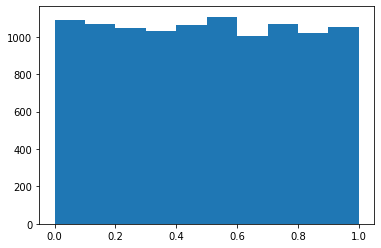

In [35]:
plt.hist(attention)

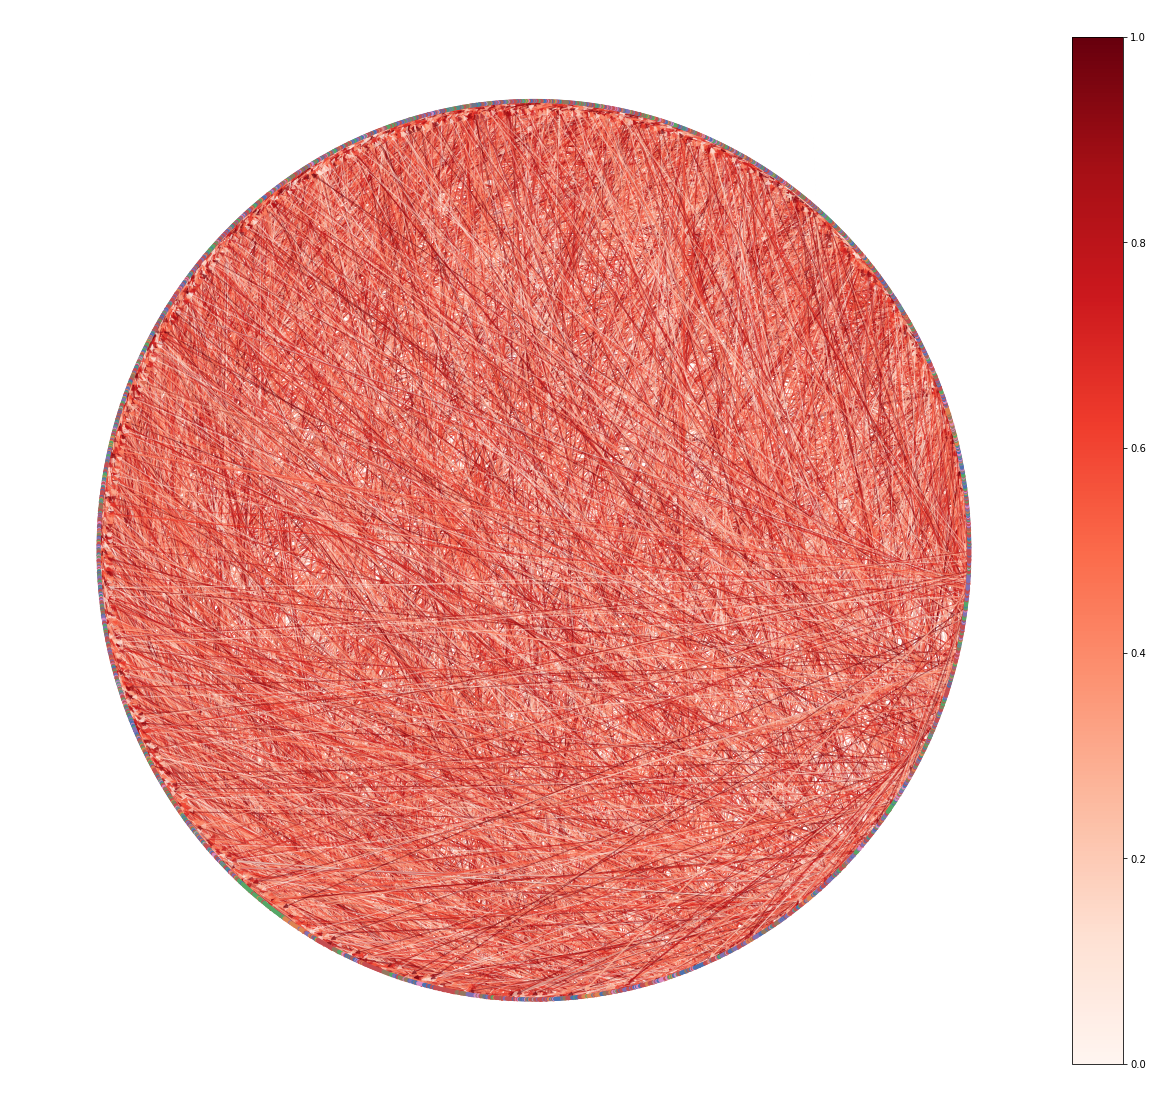

In [40]:
fig, ax = plt.subplots(figsize=(20,20))
plot(dg, attention, ax=ax, nodes_pos=nx.circular_layout(dg), nodes_labels=labels)
ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, fraction=0.046, pad=0.01)
plt.show()

In [3]:
g_dgl = DGLGraph([(0, 1), (1, 2), (1, 3)])
print(type(g_dgl))
dg = g_dgl.to_networkx().to_directed()
print(type(dg))
dg.edges()

#Y.reshape(Y.shape[0])
grEd = dg.edges()
print(grEd)

<class 'dgl.heterograph.DGLHeteroGraph'>
<class 'networkx.classes.multidigraph.MultiDiGraph'>
[(0, 1), (1, 2), (1, 3)]


C:\Users\ME\Anaconda3\envs\tf-gpu5\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


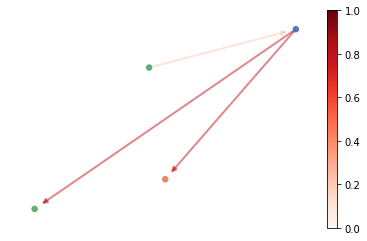

In [5]:
fig, ax = plt.subplots()
plot(dg, [0.2, 0.8, 0.8], ax=ax, nodes_pos=nx.random_layout(dg), nodes_labels=[0, 1, 2])
ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, fraction=0.046, pad=0.01)
plt.show()

In [14]:
dir(g.edata)

['_MutableMapping__marker',
 '__abstractmethods__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_abc_impl',
 '_edges',
 '_etid',
 '_etype',
 '_graph',
 'clear',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [19]:
from scipy.sparse import lil_matrix
from sklearn.preprocessing import normalize

def preprocess_attention(edge_atten, g, to_normalize=True):
    """Organize attentions in the form of csr sparse adjacency
    matrices from attention on edges. 

    Parameters
    ----------
    edge_atten : numpy.array of shape (# edges, # heads, 1)
        Un-normalized attention on edges.
    g : dgl.DGLGraph.
    to_normalize : bool
        Whether to normalize attention values over incoming
        edges for each node.
    """
    n_nodes = g.number_of_nodes()
    num_heads = edge_atten.shape[1]
    all_head_A = [lil_matrix((n_nodes, n_nodes)) for _ in range(num_heads)]
    for i in range(n_nodes):
        predecessors = list(g.predecessors(i))
        edges_id = g.edge_ids(predecessors, i)
        for j in range(num_heads):
            all_head_A[j][i, predecessors] = edge_atten[edges_id, j].data.cpu().numpy()
    if to_normalize:
        for j in range(num_heads):
            all_head_A[j] = normalize(all_head_A[j], norm='l1').tocsr()
    return all_head_A

In [23]:
# # Take the attention from one layer as an example
# # num_edges x num_heads x 1
# A = self.g.edata['a_drop']
# # list of length num_heads, each entry is csr of shape (num_nodes, num_nodes)       
# A = preprocess_attention(A, self.g)       

dict_keys(['z'])

In [20]:
# Take the attention from one layer as an example
# num_edges x num_heads x 1
A = g.edata['e']
# list of length num_heads, each entry is csr of shape (num_nodes, num_nodes)       
A = preprocess_attention(A, g)  

In [23]:
type(A[0])

scipy.sparse.csr.csr_matrix

In [29]:
A[0].nonzero()

(array([   0,    0,    0, ..., 2707, 2707, 2707], dtype=int32),
 array([ 633, 1862, 2582, ...,  598, 1473, 2706], dtype=int32))

In [27]:
A[0][0,634]

0.0

In [34]:
srcnodes = A[0].nonzero()[0].shape
dstnodes = A[0].nonzero()[1]

In [54]:
attention_list = []
for num in range(0, A[0].nonzero()[0].shape[0]):
    attention_list.append(A[0][A[0].nonzero()[0][num], A[0].nonzero()[1][num]])
attention_list = np.asarray(attention_list)

In [36]:
A[0].nonzero()[0].shape

(10556,)

In [56]:
type(attention_list)

numpy.ndarray

In [60]:
np.max(attention_list)

1.0

In [61]:
np.min(attention_list)

-1.0

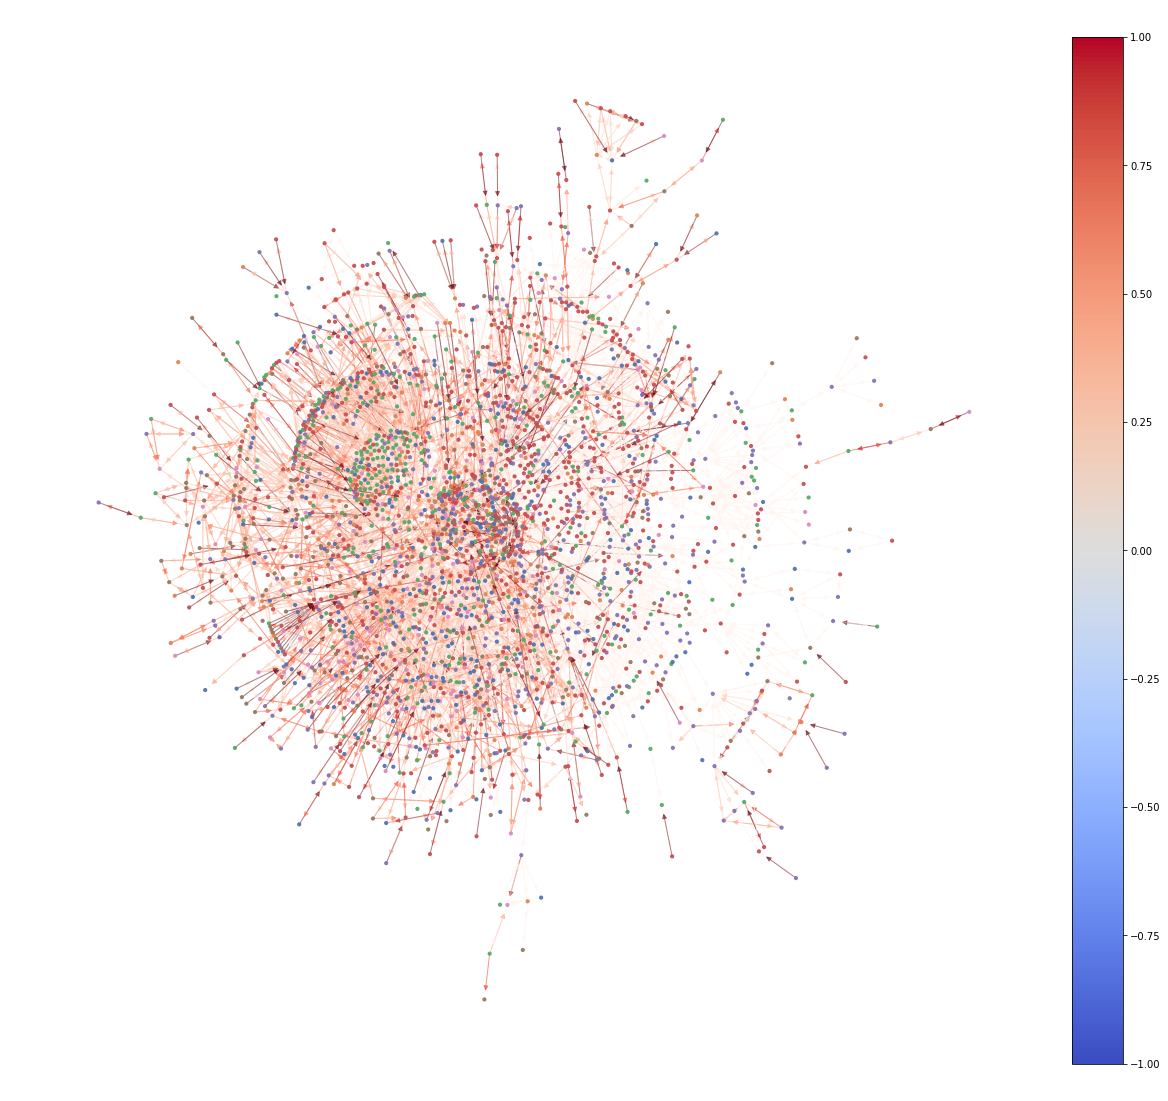

In [64]:
fig, ax = plt.subplots(figsize=(20,20))
plot(dg, attention_list, ax=ax, nodes_pos=nx.kamada_kawai_layout(dg), nodes_labels=labels)
ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=np.min(attention_list), vmax=np.max(attention_list)))
sm.set_array([])
plt.colorbar(sm, fraction=0.046, pad=0.01)
plt.show()

In [18]:
g.edata['e'].shape

torch.Size([10556, 1])

In [19]:
edge_atten = g.edata['e']

In [23]:
n_nodes = g.number_of_nodes()
num_heads = edge_atten.shape[1]

In [24]:
num_heads

1

In [25]:
all_head_A = [lil_matrix((n_nodes, n_nodes)) for _ in range(num_heads)]

In [27]:
for j in range(num_heads):
    print(j)

0


In [29]:
i=0

In [30]:
predecessors = list(g.predecessors(i))
edges_id = g.edge_ids(predecessors, i)

In [31]:
predecessors

[tensor(633), tensor(1862), tensor(2582)]

In [32]:
edges_id

tensor([ 2569,  7565, 10306])

In [35]:
edge_atten

tensor([[ 0.0761],
        [ 0.0756],
        [ 0.0737],
        ...,
        [ 0.0421],
        [-0.0006],
        [ 0.0124]], grad_fn=<LeakyReluBackward0>)

In [34]:
edge_atten[edges_id, 0]

tensor([0.0587, 0.0745, 0.0387], grad_fn=<IndexBackward>)